In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import nltk

from nltk.corpus import stopwords

from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [13]:
data = pd.read_csv('first-gop-debate-twitter-sentiment/Sentiment.csv')
df = data.copy()

In [22]:
df.head(1)

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral


In [15]:
# Keeping only necessary columns for sentiment analysis...
df = df[['text','sentiment']]

In [17]:
df.shape

(13871, 2)

In [18]:
# Splitting the data into train and test
train,test = train_test_split(df,test_size = 0.1)

In [19]:
train  = train[train.sentiment != 'Neutral']

In [23]:
train_p = train[train.sentiment == 'Positive']
train_p = train_p['text']
train_n = train[train.sentiment == 'Negative']
train_n = train_n['text']

* Cleaned word : Cleaning the text by removing hash-tags , Twitter handles and Retweets
* word cloud is for Highlighting the Positive words or Negative words (simply visualization of words from positive and negative data)

In [26]:
# function to visualize the emphatic words
def wordcloud_drawing(data,color='black'):
    words = ' '.join(data)
    cleaned_word = ' '.join([word for word in words.split()
                            if 'http' not in word
                            and not word.startswith('@')
                            and not word.startswith('#')
                            and word != 'RT'])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color=color,width=2500,
                          height=1800).generate(cleaned_word)
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


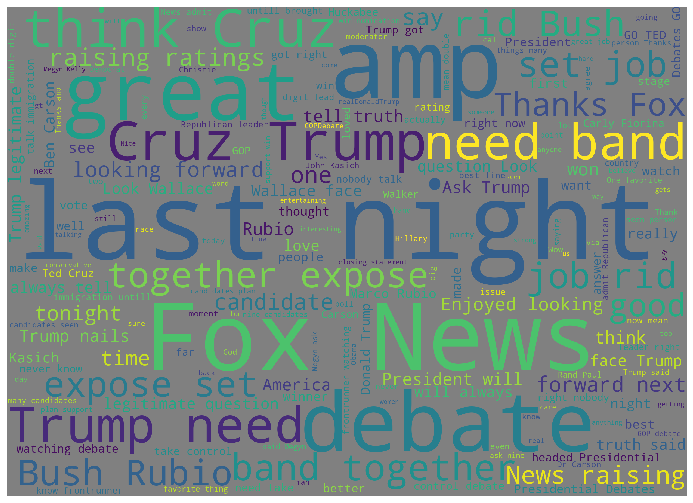

In [30]:
print("Positive words")
wordcloud_drawing(train_p,'grey')

> great , trump , last night , FOx news debate are in Positive highly

Negative words


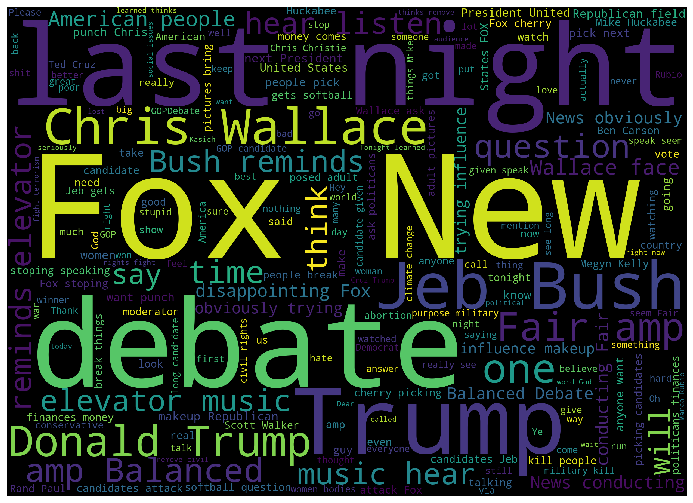

In [29]:
print("Negative words")
wordcloud_drawing(train_n,'black')

> We can observe the same type of words are used for the Negative Feedback also

* Making the tweets clean and removing the stopwords & making sure that atleast 3 words are in the sentence. 

In [35]:
tweets = []

for index , row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
                    if 'http' not in word
                    and not word.startswith('@')
                    and not word.startswith('#')
                    and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in set(stopwords.words('english'))]
    tweets.append((words_without_stopwords,row.sentiment))

In [37]:
tweets

[(['hugged', 'obama', 'deserve', 'stage', 'tonight.'], 'Negative'),
 (['hilary',
   'however',
   '&amp;',
   'win.',
   'why,',
   'talked',
   'person.',
   'know',
   "can't",
   'beat',
   'her!'],
  'Negative'),
 (['well', 'yeah...#gopdebate'], 'Positive'),
 (['rather', 'much', 'easier', 'tell', 'got', 'anything', 'right?'],
  'Negative'),
 (['donald', 'trump', 'starting', 'remind', 'guy.'], 'Negative'),
 (['chant', '"war"', 'together?'], 'Negative'),
 (['disappointing',
   'fox',
   'news',
   'conducting',
   '"fair',
   '&amp;',
   'balanced"',
   'debate.'],
  'Negative'),
 (['.@loudobbsnews', 'thank', 'look', 'forward', 'next', 'time!'], 'Positive'),
 (['resembled',
   'interview',
   'portion',
   'beauty',
   'pageant,',
   'drawn',
   'out,',
   'actual',
   'debate.'],
  'Negative'),
 (['big', 'hit', 'me?', 'nsa,', 'closing', 'statements'], 'Positive'),
 (['pick', 'winner', 'would', 'first', 'choice.', 'followed'], 'Positive'),
 (['ppl',
   'say',
   'needs',
   'specific

> Extracting the Word Features and Filtering

In [49]:
tweets[1] # Tuples of list of words and Sentiment are stored in tweets

(['hilary',
  'however',
  '&amp;',
  'win.',
  'why,',
  'talked',
  'person.',
  'know',
  "can't",
  'beat',
  'her!'],
 'Negative')

In [51]:
# Extracting Features
def get_wrds_frm_tweets(tweets):
    all =[]
    for (words,sentiment) in tweets:
        all.extend(words)
    return all
def get_wrd_featrs(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

In [53]:
w_features  = get_wrd_featrs(get_wrds_frm_tweets(tweets))

In [55]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

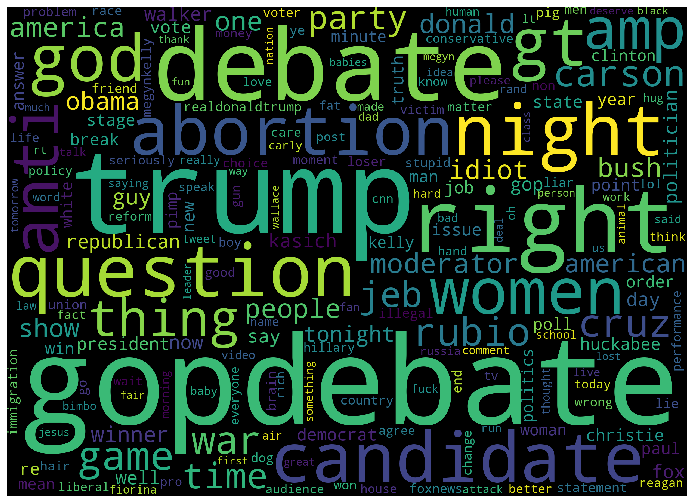

In [54]:
wordcloud_drawing(w_features)

* using nltk naivebayes classifier

In [57]:
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [58]:
test_p = test[ test['sentiment'] == 'Positive']
test_p = test_p['text']
test_n = test[ test['sentiment'] == 'Negative']
test_n = test_n['text']

In [59]:
n_cnt = 0
p_cnt = 0

for i in test_n:
    res = classifier.classify(extract_features(i.split()))
    if res == 'Negative' :
        n_cnt+=1
for i in test_p:
    res = classifier.classify(extract_features(i.split()))
    if res == 'Positive':
        p_cnt+=1

In [62]:
print(f'Negative_correct : {n_cnt}/{len(test_n)}')
print(f'Postive_correct : {p_cnt}/{len(test_p)}')

Negative_correct : 796/839
Postive_correct : 79/228


> I think the data set is having more negative sentiment than the Positive..because it seems like over fitting the data

In [63]:
data.sentiment.describe()

count        13871
unique           3
top       Negative
freq          8493
Name: sentiment, dtype: object

In [66]:
data.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

* Yup , The data is imbalanced